In [2]:
# standard libraries
import time
import pandas as pd
import numpy as np
from sklearn import preprocessing
from pathlib import Path
# import urllib.request
# from pathlib import Path
# from urllib.error import HTTPError
from tqdm.notebook import tqdm 

# Pytorch and Pytorch Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Visualization and plotting
import umap
import plotly.express as px
# Tensorboard extension
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

2022-10-31 23:35:21.022800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def transform_meta (metadata):
    df = metadata.copy()
    colsNum = df.select_dtypes(np.number).columns
    colsObj = df.columns.difference(colsNum)
    df[colsNum] = df[colsNum].fillna(df[colsNum].mean()//1)
    df[colsObj] = df[colsObj].fillna(df[colsObj].mode().iloc[0])
    
    encoder = {}
    
    for col in colsObj:
        encoder[col] = preprocessing.LabelEncoder()
        df[col] = encoder[col].fit_transform(df[col])
        
    return df, encoder

In [4]:
def load_data(rna, pro, meta_data, verbose = True):
    assert all(rna.index == pro.index), "RNA and protein data cell barcodes do not match!"
    citeseq = pd.concat([rna, pro], axis=1)
    if verbose: print("shape of concantenated df is:",citeseq.shape)
    # citeseq = torch.tensor(citeseq.to_numpy(), dtype = torch.float) 
    # meta_data = transform_meta(metadata)
    
    dataset = CustomDataset(citeseq, meta_data)
    
    if all(rna.index == pro.index): return dataset, meta_data

In [5]:
class CustomDataset(Dataset):
    def __init__(self, citeseq_df, metadata_df):
        self.data = torch.tensor(citeseq_df.to_numpy(), dtype = torch.float)
        self.metadata = metadata_df.to_numpy()
        #self.transform = transforms.Compose([transforms.ToTensor()]) 
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx): # loads and returns a sample from the dataset at the given index idx. 
        x = self.data[idx]
        y = self.metadata[idx]
        return x, y

In [ ]:
def split_dataset(rna, pro, meta_data, random_seed=0, batch_size = 256):
    dataset, meta_data = load_data(rna, pro, meta_data, verbose = True)
    ncells = rna.shape[0] # Number of cells
    rna_num = rna.shape[1] # Number of genes
    pro_num = pro.shape[1] # Number of proteins
    
    # train, validation, and test split
    train_size = int(ncells*0.7)
    val_size = int(ncells*0.15)
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, ncells-train_size-val_size],
                                         generator=torch.Generator().manual_seed(random_seed))
    
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
    val_dataloader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False,num_workers=0)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False,num_workers=0)
    
    return train_dataloader, val_dataloader, test_dataloader, ncells, rna_num, pro_num

# train_dataloader, val_dataloader, test_dataloader,ncells, rna_num, pro_num = split_dataset(rna, pro, meta_data, random_seed=0)

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [17]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from pathlib import Path
CHECKPOINT_PATH = Path("saved_pytorch_models")
if not CHECKPOINT_PATH.exists():
    CHECKPOINT_PATH.mkdir()

In [68]:
class Encoder(nn.Module):
    def __init__ (self, rna_num, pro_num, hidden_rna, hidden_pro, latent_dim, p: float = 0):
        super().__init__()
        self.rna_num = rna_num 
        self.pro_num = pro_num 
        hidden_dim = hidden_rna + hidden_pro 
        
        self.encoder_rna = nn.Sequential(
        # https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd
            nn.Linear(rna_num, rna_num//2, bias = False),
            nn.LeakyReLU(),
            nn.BatchNorm1d(rna_num//2), ## apply batch norm 
            nn.Dropout(p),
            nn.Linear(rna_num//2, hidden_rna),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_rna)
        )
        
        self.encoder_protein = nn.Sequential(
            nn.Linear(pro_num, hidden_pro),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_pro),
            nn.Dropout(p)
        )
        
        self.encoder = nn.Sequential(
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(latent_dim)
        )
        
    def forward(self, x): # feed data forward
        x_rna = self.encoder_rna(x[:, :self.rna_num])
        x_pro = self.encoder_protein(x[:, self.rna_num:]) #not sure why not pro_num
        x = torch.cat([x_rna, x_pro], 1)
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__ (self, rna_num, pro_num, hidden_rna, hidden_pro, latent_dim):
        super().__init__()
        hidden_dim = hidden_rna + hidden_pro 
        output_dim = rna_num + pro_num 
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, output_dim//2),
            nn.LeakyReLU(),
            nn.BatchNorm1d(output_dim//2),
            nn.Linear(output_dim//2, output_dim, bias= True)
        )
        
    def forward(self, x):
        return self.decoder(x)

In [69]:
## Autoencoder 
# encode gene and protein data with different encoders since they have different dimensions
# concatenate outputs before passing it through another encoder to generate bottleneck layer 
# We can change the neural network architecture given 

class Cite_Autoencoder(pl.LightningModule):
    
    def __init__(self, rna_num, pro_num, hidden_rna, hidden_pro, latent_dim, p: float = 0, learning_rate: float = 0.1):
        super().__init__()
        
        # save hyperparamteters??
        #self.save_hyperparameters()
        self.encoder = Encoder(rna_num, pro_num, hidden_rna, hidden_pro, latent_dim, p)
        self.decoder = Decoder(rna_num, pro_num, hidden_rna, hidden_pro, latent_dim)
        self.learning_rate = learning_rate
    
    def forward(self, x):
        # extract latent embeddings 
        return self.encoder(x)
    
    #Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}
    
    def _get_reconstruction_loss(self, batch):
        """ Calculate MSE loss for a given batch. """
        x, _ = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        # MSE loss
        loss = F.mse_loss(x_hat, x)
        return loss
    
    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("val_loss", loss)
        
    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log("test_loss", loss)

In [70]:
def train_citeseq(hidden_rna: int = 30, hidden_pro: int = 18,
                 latent_dim: int = 24, p: float = 0.1, lr: float = 0.05, epoch = 15):
    
    #  use gpu if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    CHECKPOINT_PATH = Path("saved_pytorch_models")
    if not CHECKPOINT_PATH.exists():
        CHECKPOINT_PATH.mkdir()
    
    model = Cite_Autoencoder(rna_num, pro_num,
                             hidden_rna = hidden_rna, hidden_pro = hidden_pro,
                             latent_dim = latent_dim, p = p, learning_rate = lr)
    
    trainer = pl.Trainer(default_root_dir=CHECKPOINT_PATH,
                         gpus=1 if "cuda" in str(device) else 0,
                         max_epochs=epoch,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                    LearningRateMonitor("epoch")])
    
    trainer.fit(model, train_dataloader, val_dataloader)
    
    train_result = trainer.test(model, train_dataloader, verbose = False)
    val_result = trainer.test(model, val_dataloader, verbose=False)
    test_result = trainer.test(model, test_dataloader, verbose=False)
    
    result = {"train": train_result, "val": val_result, "test": test_result}
    
    return model, result
    

In [ ]:
def inverse_transform_meta(test_dataloader, model, metadata, encoder):
    test_encodings = []
    test_labels = []
    with torch.no_grad():
        for x,y in test_dataloader:
            test_encodings.append(model(x.to(model.device)))
            test_labels += y.to(torch.int).tolist()
    test_df = pd.DataFrame(test_labels, columns = metadata.columns)
    colsNum = metadata.select_dtypes(np.number).columns
    colsObj = test_df.columns.difference(colsNum)
    
    for col in colsObj: 
        test_df[col] = encoder[col].inverse_transform(test_df[col])
        
    test_embeds = torch.cat(test_encodings, dim=0).cpu().numpy()
    test_labels_df = test_df.copy()
    
    return test_labels_df, test_embeds

In [71]:
### TRIAL 

In [ ]:
# User specify dataset (each column is a gene/metadata feature and each row is a cell)
rna = pd.read_csv("Sample Datasets/GSE128639/rna_scale.csv.gz",index_col=0).T
pro = pd.read_csv("Sample Datasets/GSE128639/protein_scale.csv.gz", index_col=0).T
# User specify dataset if any 
metadata = pd.read_csv("Sample Datasets/GSE128639/metadata.csv.gz",index_col=0)
metadata['cell_barcode'] = metadata.index # to preserve cell barcode

In [ ]:
meta_data, encoder = transform_meta(metadata)

In [ ]:
train_dataloader, val_dataloader, test_dataloader,ncells, rna_num, pro_num = split_dataset(rna, pro, meta_data, random_seed=0)

In [ ]:
model, result = train_citeseq(epoch= 50)

In [ ]:
print(f"Training loss:  {result['train'][0]['test_loss']:.3f}")
print(f"Validation loss:  {result['val'][0]['test_loss']:.3f}")
print(f"Test loss: {result['test'][0]['test_loss']:.3f}")

In [78]:
test_labels_df, test_embeds = inverse_transform_meta(test_dataloader, model, metadata, encoder)
    

In [79]:
# run umap for dimensionality reduction and visualization # epoch = 20
embeds_umap = umap.UMAP(random_state=0).fit_transform(test_embeds)

plot_df = test_labels_df.copy()
plot_df["UMAP1"] = embeds_umap[:, 0]
plot_df["UMAP2"] = embeds_umap[:, 1]
fig = px.scatter(plot_df, x="UMAP1", y="UMAP2", color='celltype.l2')
fig.update_traces(marker=dict(size=4))
fig.show()

In [80]:
fig = px.scatter(plot_df, x="UMAP1", y="UMAP2", color='celltype.l1')
fig.update_traces(marker=dict(size=4))
fig.show()

In [ ]:
#get deg

In [75]:
# run umap for dimensionality reduction and visualization # epoch = 10
embeds_umap = umap.UMAP(random_state=0).fit_transform(test_embeds)

plot_df = test_labels_df.copy()
plot_df["UMAP1"] = embeds_umap[:, 0]
plot_df["UMAP2"] = embeds_umap[:, 1]
fig = px.scatter(plot_df, x="UMAP1", y="UMAP2", color='celltype.l2')
fig.update_traces(marker=dict(size=4))
fig.show()

In [19]:
fig = px.scatter(plot_df, x="UMAP1", y="UMAP2", color='celltype.l1')
fig.update_traces(marker=dict(size=4))
fig.show()

In [82]:
test_encodings = []
test_labels = []
    
# model.eval()
with torch.no_grad():    
    for x, y in tqdm(test_dataloader, desc="Encoding cells"):
        test_encodings.append(model(x.to(model.device)))
        test_labels += y.to(torch.int).tolist()
test_df = pd.DataFrame(test_labels, columns = meta_data.columns)
colsNum = metadata.select_dtypes(np.number).columns
colsObj = test_df.columns.difference(colsNum)
print(colsObj)
for col in colsObj: 
    print(col)
    test_df[col] = encoder[col].inverse_transform(test_df[col])

test_embeds = torch.cat(test_encodings, dim=0).cpu().numpy()

Encoding cells:   0%|          | 0/18 [00:00<?, ?it/s]

Index(['cell_barcode', 'celltype.l1', 'celltype.l2', 'donor', 'lane',
       'orig.ident'],
      dtype='object')
cell_barcode
celltype.l1
celltype.l2
donor
lane
orig.ident


In [88]:
import matplotlib as plt

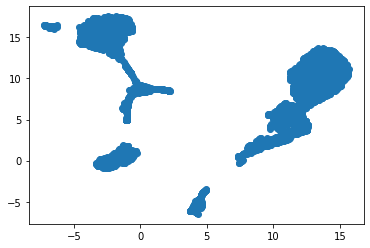

In [94]:
plt.pyplot.scatter(plot_df["UMAP1"], plot_df["UMAP2"])#, #color='celltype.l2')

In [81]:
model

Cite_Autoencoder(
  (encoder): Encoder(
    (encoder_rna): Sequential(
      (0): Linear(in_features=2000, out_features=1000, bias=False)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
      (4): Linear(in_features=1000, out_features=30, bias=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (encoder_protein): Sequential(
      (0): Linear(in_features=25, out_features=18, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.1, inplace=False)
    )
    (encoder): Sequential(
      (0): Linear(in_features=48, out_features=24, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_runn

In [88]:
# User specify dataset (each column is a gene/metadata feature and each row is a cell)
rna = pd.read_csv("data/GSE166489/Normal/GSM5073072/rna_scale.csv.gz",index_col=0).T
pro = pd.read_csv("data/GSE166489/Normal/GSM5073072/protein_scale.csv.gz", index_col=0).T 
metadata = pd.read_csv("data/GSE166489/Normal/GSM5073072/metadata.csv.gz",index_col=0)
metadata['cell_barcode'] = metadata.index # to preserve cell barcode
meta_data, encoder = transform_meta(metadata)
#train_dataloader, val_dataloader, test_dataloader,ncells, rna_num, pro_num = split_dataset(rna, pro, meta_data, random_seed=0)


In [89]:
train_dataloader, val_dataloader, test_dataloader,ncells, rna_num, pro_num = split_dataset(rna, pro, meta_data, random_seed=0)

shape of concantenated df is: (11561, 2189)


In [ ]:
#train_dataloader, val_dataloader, test_dataloader,ncells, rna_num, pro_num = split_dataset(rna, pro, meta_data, random_seed=0)
model, result = train_citeseq(epoch= 20)

/Users/ting/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 2.0 M 
1 | decoder | Decoder | 2.5 M 
------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.963    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/ting/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/ting/opt/anaconda3/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'CustomDataset' on <module '__main__' (built-in)>


In [86]:
metada

,orig.ident,nCount_RNA,nFeature_RNA,nCount_ADT,nFeature_ADT,nCount_SCT,nFeature_SCT,predicted.celltype.l1.score,predicted.celltype.l1,predicted.celltype.l2.score,predicted.celltype.l2
AAACCTGAGAGTCGGT-1,SeuratProject,2958,1061,4858,180,3475,1061,0.964647,other T,0.595623,gdT
AAACCTGAGATACACA-1,SeuratProject,2905,1359,2861,162,3374,1359,1.000000,NK,1.000000,NK
AAACCTGAGGATTCGG-1,SeuratProject,3653,1291,2895,163,3691,1291,0.866726,CD4 T,0.639557,CD4 TCM
AAACCTGAGTCCAGGA-1,SeuratProject,974,38,851,138,2899,328,0.951388,other,0.777352,Eryth
AAACCTGCAATGCCAT-1,SeuratProject,2084,1037,2114,162,3257,1048,0.915474,NK,0.915474,NK
...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCATCGTCTGCT-1,SeuratProject,3603,1153,5127,174,3682,1152,1.000000,B,0.977447,B naive
TTTGTCATCTATGTGG-1,SeuratProject,2432,1189,10138,185,3257,1190,1.000000,Mono,0.971371,CD14 Mono
TTTGTCATCTCTAGGA-1,SeuratProject,2204,1082,4724,180,3228,1096,1.000000,Mono,0.949151,CD14 Mono
TTTGTCATCTGGCGAC-1,SeuratProject,5746,1990,8368,182,4319,1974,1.000000,Mono,1.000000,CD14 Mono


In [ ]:
# User specify dataset (each column is a gene/metadata feature and each row is a cell)
rna = pd.read_csv("data/GSE100866/rna_scale.csv.gz",index_col=0).T
pro = pd.read_csv("data/GSE100866/protein_scale.csv.gz", index_col=0).T
# User specify dataset if any 
metadata = pd.read_csv("data/GSE100866/metadata.csv.gz",index_col=0)
metadata['cell_barcode'] = metadata.index # to preserve cell barcode
meta_data, encoder = transform_meta(metadata)
train_dataloader, val_dataloader, test_dataloader,ncells, rna_num, pro_num = split_dataset(rna, pro, meta_data, random_seed=0)
model, result = train_citeseq(epoch= 20)

In [ ]:
test_labels_df, test_embeds = inverse_transform_meta(test_dataloader, model, metadata, encoder)

In [ ]:
# run umap for dimensionality reduction and visualization # epoch = 20
embeds_umap = umap.UMAP(random_state=0).fit_transform(test_embeds)

plot_df = test_labels_df.copy()
plot_df["UMAP1"] = embeds_umap[:, 0]
plot_df["UMAP2"] = embeds_umap[:, 1]
fig = px.scatter(plot_df, x="UMAP1", y="UMAP2", color='celltype.l2')
fig.update_traces(marker=dict(size=4))
fig.show()